# PyTorch Neural Network Model


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.12.7 (main, Oct 16 2024, 07:12:08) [Clang 18.1.8 ]
PyTorch version 2.10.0
Torchvision version 0.25.0
Numpy version 2.4.2
Pandas version 3.0.0


## Step 1. PyTorch Dataset and Dataloader


Dataset can be downloaded from Kaggle: [link](https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification)


In [2]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [16]:
data_dir = '../data/playingcards/train'

In [ ]:
dataset = PlayingCardDataset(
    data_dir=data_dir
)
len(dataset)

7624

Image Label: 7, classes: eight of spades


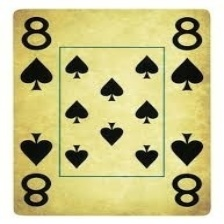

In [15]:
image, label = dataset[1121]
print(f"Image Label: {label}, classes: {dataset.classes[label]}")
image

In [17]:
ImageFolder(data_dir).class_to_idx

{'ace of clubs': 0,
 'ace of diamonds': 1,
 'ace of hearts': 2,
 'ace of spades': 3,
 'eight of clubs': 4,
 'eight of diamonds': 5,
 'eight of hearts': 6,
 'eight of spades': 7,
 'five of clubs': 8,
 'five of diamonds': 9,
 'five of hearts': 10,
 'five of spades': 11,
 'four of clubs': 12,
 'four of diamonds': 13,
 'four of hearts': 14,
 'four of spades': 15,
 'jack of clubs': 16,
 'jack of diamonds': 17,
 'jack of hearts': 18,
 'jack of spades': 19,
 'joker': 20,
 'king of clubs': 21,
 'king of diamonds': 22,
 'king of hearts': 23,
 'king of spades': 24,
 'nine of clubs': 25,
 'nine of diamonds': 26,
 'nine of hearts': 27,
 'nine of spades': 28,
 'queen of clubs': 29,
 'queen of diamonds': 30,
 'queen of hearts': 31,
 'queen of spades': 32,
 'seven of clubs': 33,
 'seven of diamonds': 34,
 'seven of hearts': 35,
 'seven of spades': 36,
 'six of clubs': 37,
 'six of diamonds': 38,
 'six of hearts': 39,
 'six of spades': 40,
 'ten of clubs': 41,
 'ten of diamonds': 42,
 'ten of hearts':

In [ ]:
# Get a dictionary associating target values with folder names
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

Images must be the same size


In [18]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
dataset = PlayingCardDataset(
    data_dir=data_dir,
    transform=transform)

In [20]:
image, label = dataset[1121]
print(f"Image Label: {label}, classes: {dataset.classes[label]}")
image.shape

Image Label: 7, classes: eight of spades


torch.Size([3, 128, 128])

In [21]:
# iterate over dataset
for image, label in dataset:
    break

### Dataloaders

- Batching our dataset
- It's faster to train the model in batches instead of one at a time.


In [22]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [23]:
for images, labels in dataloader:
    break

In [26]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [25]:
labels

tensor([ 5,  6, 19, 40,  7, 22, 11, 21,  8, 52, 11,  1,  1, 22, 32, 25,  5, 19,
        36, 30, 35, 37, 22, 23, 14, 48, 23,  9,  4,  0, 32,  7])

## Step 2. PyTorch Model

PyTorch datasets have a structured way of organizing your data, pytorch models follow a similar paradigm.

We could create the model from scratch defining each layer. However for tasks like image classification, many of the state of the art architectures are readily available and we can import them from packages like timm.

Understanding the pytorch model is all about understanding the shape the data is at each layer, and the main one we need to modify for a task is the final layer. Here we have 53 targets, so we will modify the last layer for this.


### EfficientNet-B0

EfficientNet-b0 is a convolutional neural network that is trained on more than a million images from the ImageNet database.

It is the baseline, most compact, and computationally efficient CNN in the EfficientNet family, developed by Google AI in 2019. It was designed to achieve state-of-the-art accuracy on image classification tasks (such as ImageNet) while being significantly smaller and faster than previous models, using only about 5.3 million parameters.

EfficientNet can be used not only for image classification but also for other tasks such as object detection, segmentation, and transfer learning. Its efficiency makes it a good choice for applications where computational resources are limited, such as mobile apps, autonomous systems, and cloud-based AI services.


### Transfer Learning

We want to build on pre-existing models for image classification: let's use the `efficientnet_b0` pre-trained by Google.

Let's start a pretrained EfficientNet-B0 model and strips off its final classification layer so we can replace it with out own. Let's decompose it from the inside out.

#### 1. self.base_model — The pretrained model

```
self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
```

This loads an EfficientNet-B0 that was pretrained on ImageNet (1000 classes). The model is a nested nn.Module containing many child sub-modules (convolutional blocks, batch norm layers, a global pooling layer, and a final classification head).

#### 2. `.children()` — Get the top-level sub-modules

self.base_model.children() returns a Python generator that yields the model's immediate (top-level) child modules, in the order they were registered. For EfficientNet-B0, this is roughly:

| Index | Child Module           | Purpose                                        |
| ----- | ---------------------- | ---------------------------------------------- |
| 0     | Conv2dSame (conv_stem) | Initial stem convolution                       |
| 1     | BatchNormAct2d (bn1)   | Batch norm + activation after stem             |
| 2     | Sequential (blocks)    | The 7 MBConv blocks (the "backbone")           |
| 3     | Conv2d (conv_head)     | 1×1 conv expanding channels to 1280            |
| 4     | BatchNormAct2d (bn2)   | Batch norm + activation after conv_head        |
| 5     | SelectAdaptivePool2d   | (global_pool) Global average pooling           |
| 6     | Linear (classifier)    | Final FC layer: 1280 → 1000 (ImageNet classes) |

The last child (index 6) is the classification head that maps 1280 features to the 1000 ImageNet classes. We don't want that — we want to classify 53 playing cards, not 1000 ImageNet categories.

#### 3. list(...) — Materialize the generator into a list

`children()` returns a generator, which doesn't support slicing. Wrapping it in `list()` converts it to a Python list so we can use slice notation:

```
children_list = list(self.base_model.children())
# [Conv2dSame, BatchNormAct2d, Sequential, Conv2d, BatchNormAct2d, SelectAdaptivePool2d, Linear]
```

#### 4. `[:-1]` — Remove the last module

Python slice [:-1] means "everything except the last element." This drops the final Linear classifier layer:

```
children_list[:-1]
# [Conv2dSame, BatchNormAct2d, Sequential, Conv2d, BatchNormAct2d, SelectAdaptivePool2d]
#                                                                       ^-- stops here
#  The Linear(1280, 1000) is GONE
```

#### 5. \*list(...) — Unpack the list as positional arguments

The \* (splat/unpack) operator expands the list elements into separate arguments. This is necessary because nn.Sequential() expects each sub-module as a separate positional argument, not a single list:

```
# What * does:
nn.Sequential(*[module_a, module_b, module_c])
# is equivalent to:
nn.Sequential(module_a, module_b, module_c)

# Without *, this would FAIL:
nn.Sequential([module_a, module_b, module_c])  # ERROR: list is not a Module
```

#### 6. nn.Sequential(...) — Wrap into a new sequential container

nn.Sequential creates a container that passes input through each sub-module in order, feeding the output of one as the input to the next. The result is a clean, callable feature extractor:

```
self.features = nn.Sequential(*list(self.base_model.children())[:-1])
# self.features: input image → stem → blocks → conv_head → bn → pool → 1280-dim vector
```

### Why transfer learning?

Keep the feature extractor — The convolutional layers already know how to extract visual features (edges, textures, shapes) from millions of ImageNet images. These features are general enough to be useful for recognizing playing cards too.

Replace the classifier — The original 1000-class ImageNet head is useless for your 53-card task. You replace it with a fresh Linear(1280, 53) that will be trained on your playing card data.
Train efficiently — Instead of training a deep CNN from scratch (which would need far more data and time), you only need to fine-tune the new classifier (and optionally the backbone) on your smaller playing card dataset.


In [27]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        # where we define all parts of the model
        super(SimpleCardClassifier, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        # make a classifier
        enet_out_size = 1280
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes),
        )
    
    def forward(self, x):
        # connect these parts and return the output
        x = self.features(x)
        x = self.classifier(x)
        return x

In [29]:
model = SimpleCardClassifier(num_classes=53)
type(model)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

__main__.SimpleCardClassifier

In [31]:
print(str(model))

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (

In [32]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

## Step 3. The training loop

Now that we understand the general paradigm of pytorch datasets and models, we need to create the process of training this model.
Some things to consider: We want to validate our model on data it has not been trained on, so usually we split our data into a train and validate datasets (I have whole videos on this). This is easy because we can just create two datasets using our existing class.

**Terms:**

- Epoch: One run through the entire training dataset.
- Step: One batch of data as defined in our dataloader

This loop is one you will become familiar with when training models, you load in data to the model in batches - then calculate the loss and perform backpropagation. There are packages that package this for you, but it's good to have at least written it once to understand how it works.

Two things to select:

- optimizer, adam is the best place to start for most tasks.
- loss function: What the model will optimize for.


In [33]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 53]) torch.Size([32])


In [35]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '../data/playingcards/train/'
valid_folder = '../data/playingcards/valid/'
test_folder = '../data/playingcards/test/'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Simple Training Loop


In [37]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.5538164598619075, Validation loss: 0.4821264127515397


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5938665426540475, Validation loss: 0.2084534654077494


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.36384507715076614, Validation loss: 0.18518331050872802


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.2483652111803497, Validation loss: 0.13057003977163784


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.17960019340076075, Validation loss: 0.20875917965511107


## Visualize Losses

We can plot our training and validation loss through this training, usually we do this at the end of each epoch. We see that our accuracy on the validation dataset is x! There are a LOT more things to learn about that can drastically improve how to train a model which I will cover in future videos, but this should give you a good start!


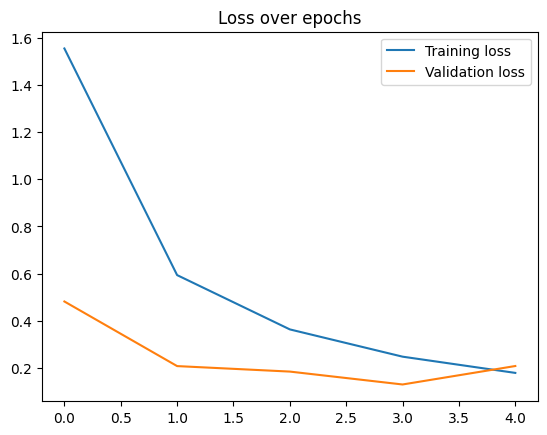

In [38]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()


## Evaluating the Results


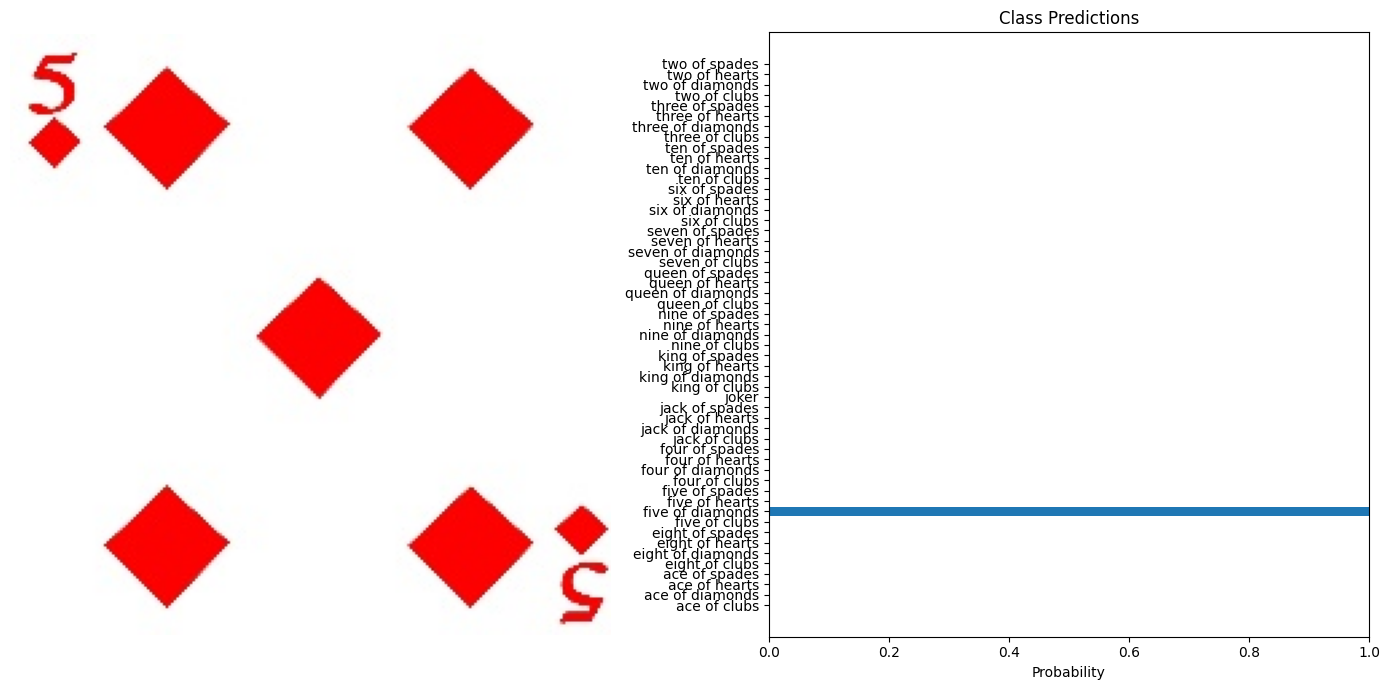

In [39]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "../data/playingcards/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

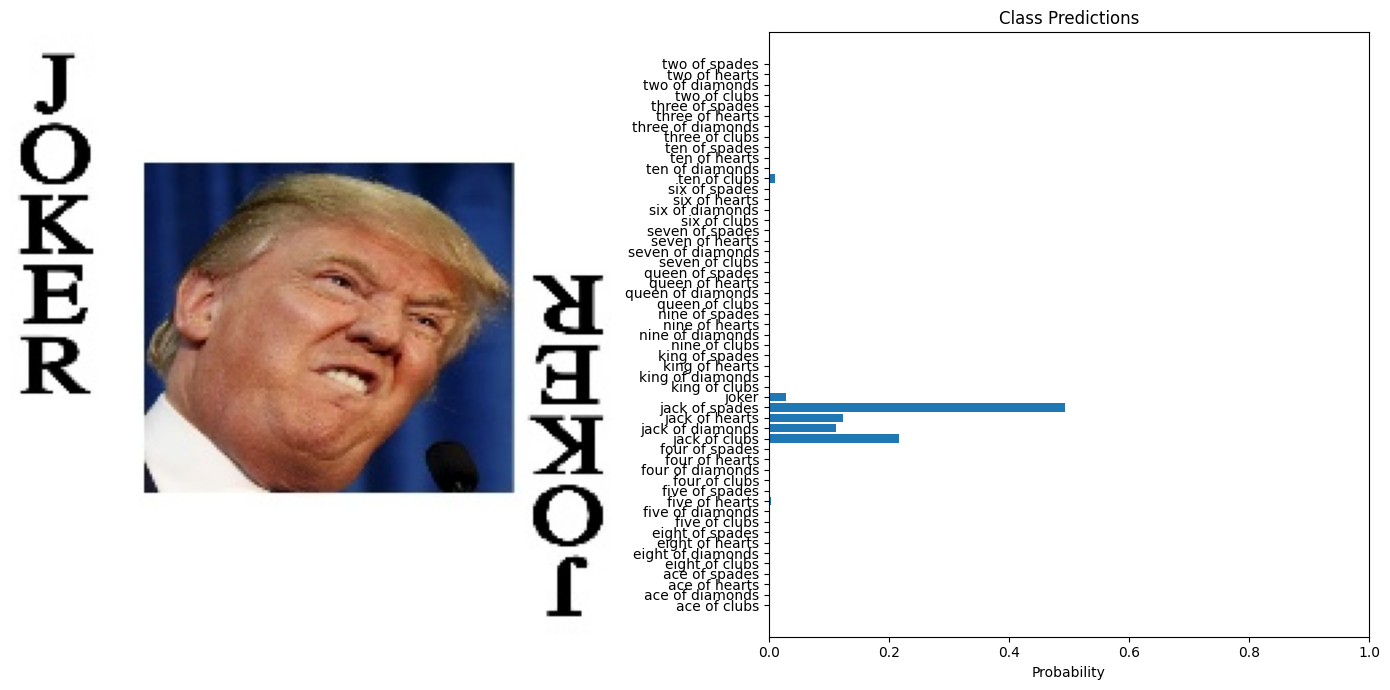

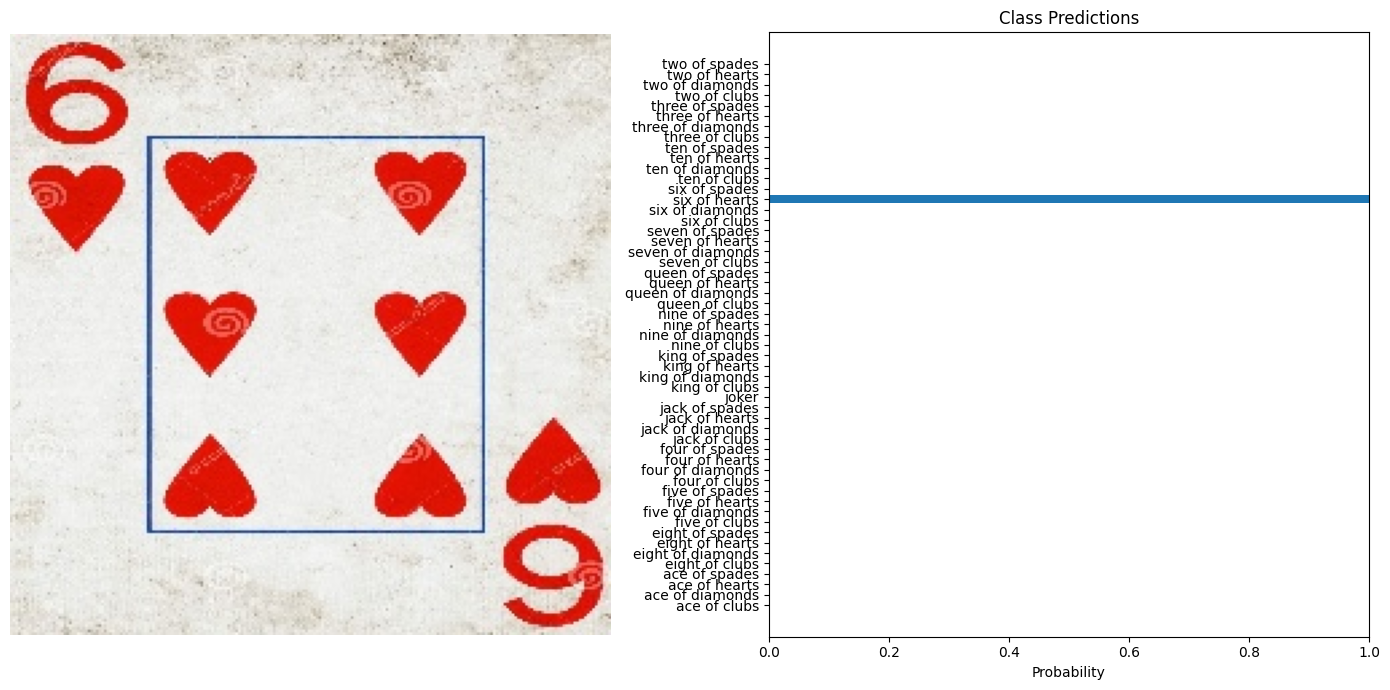

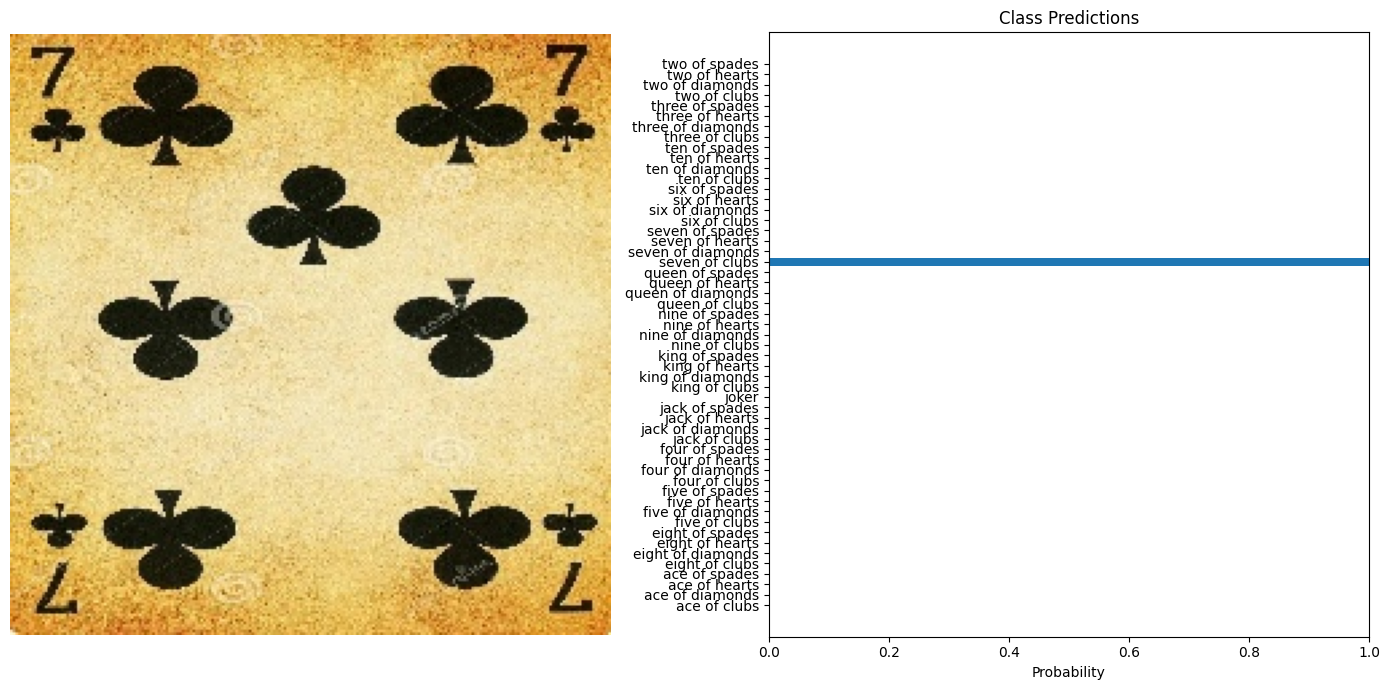

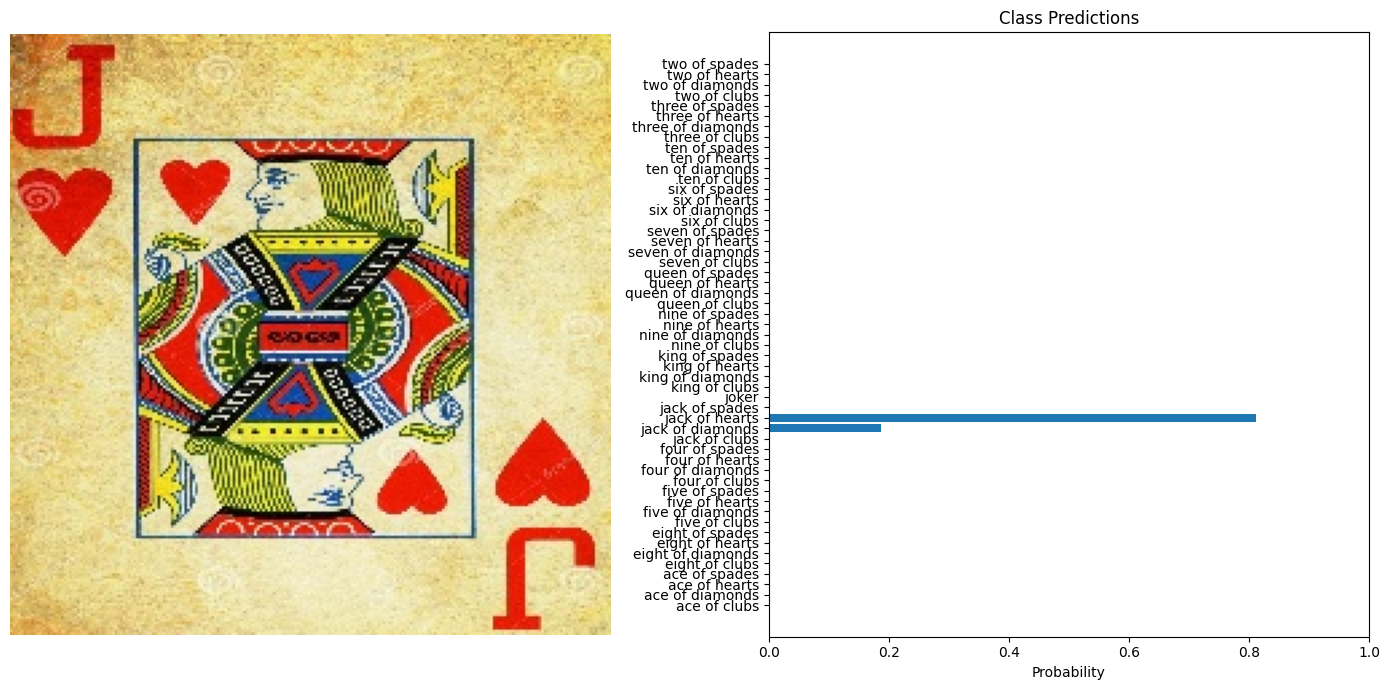

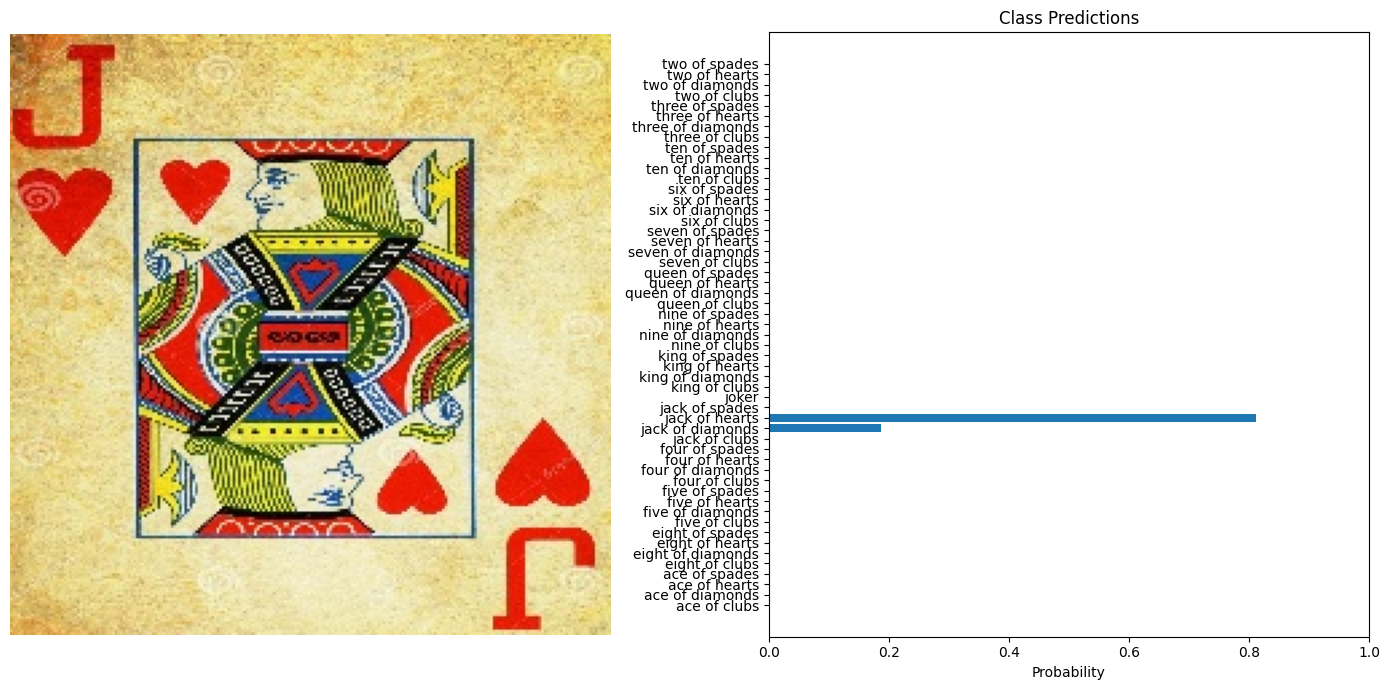

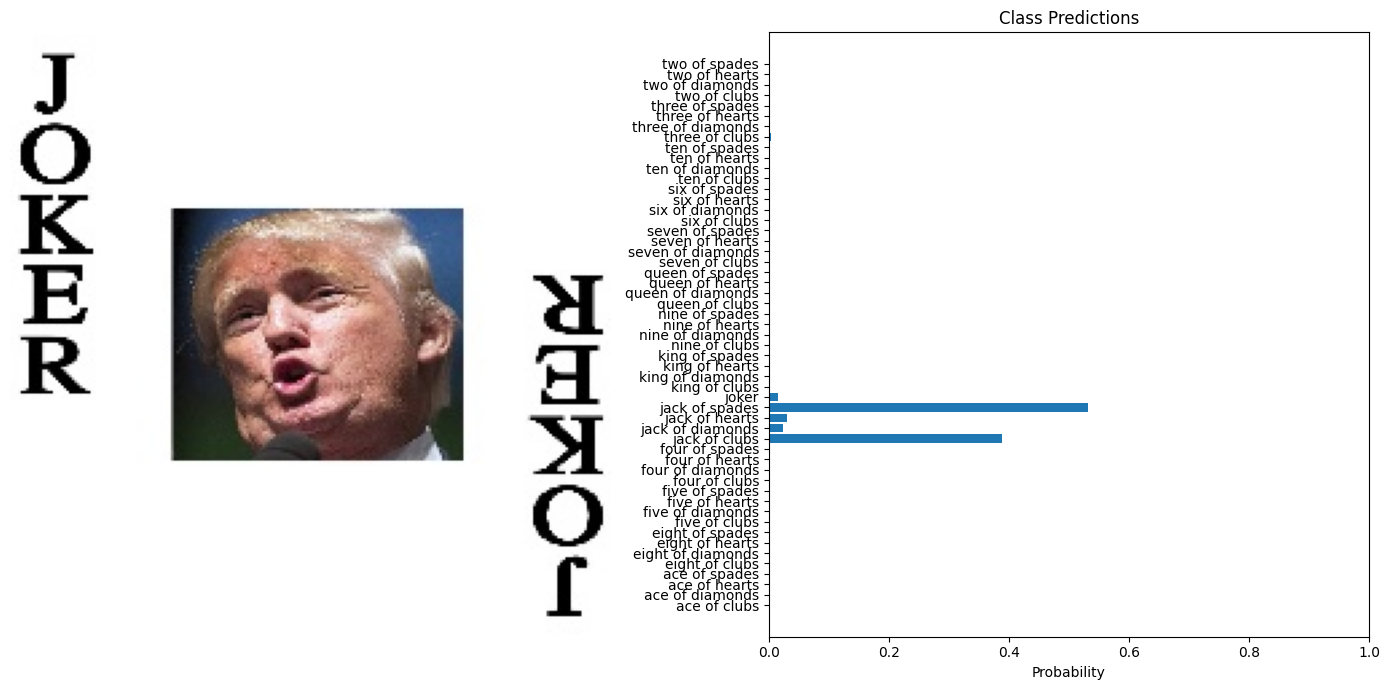

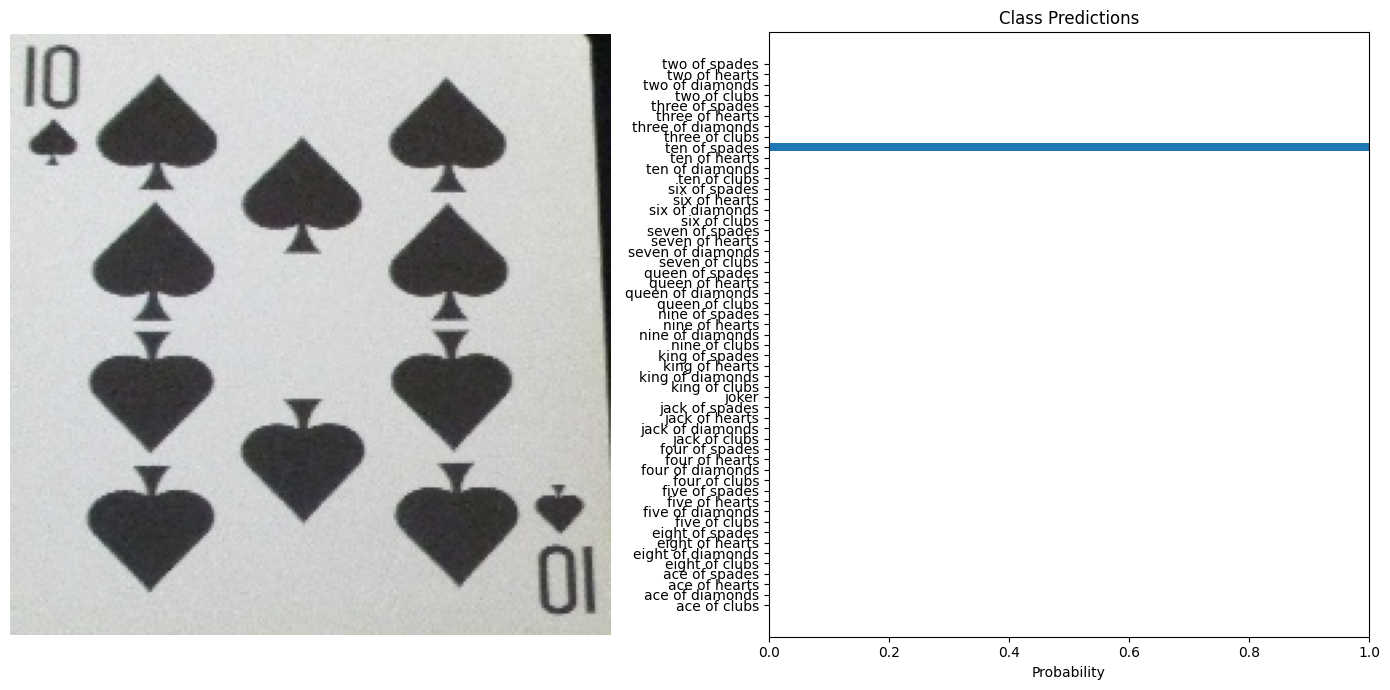

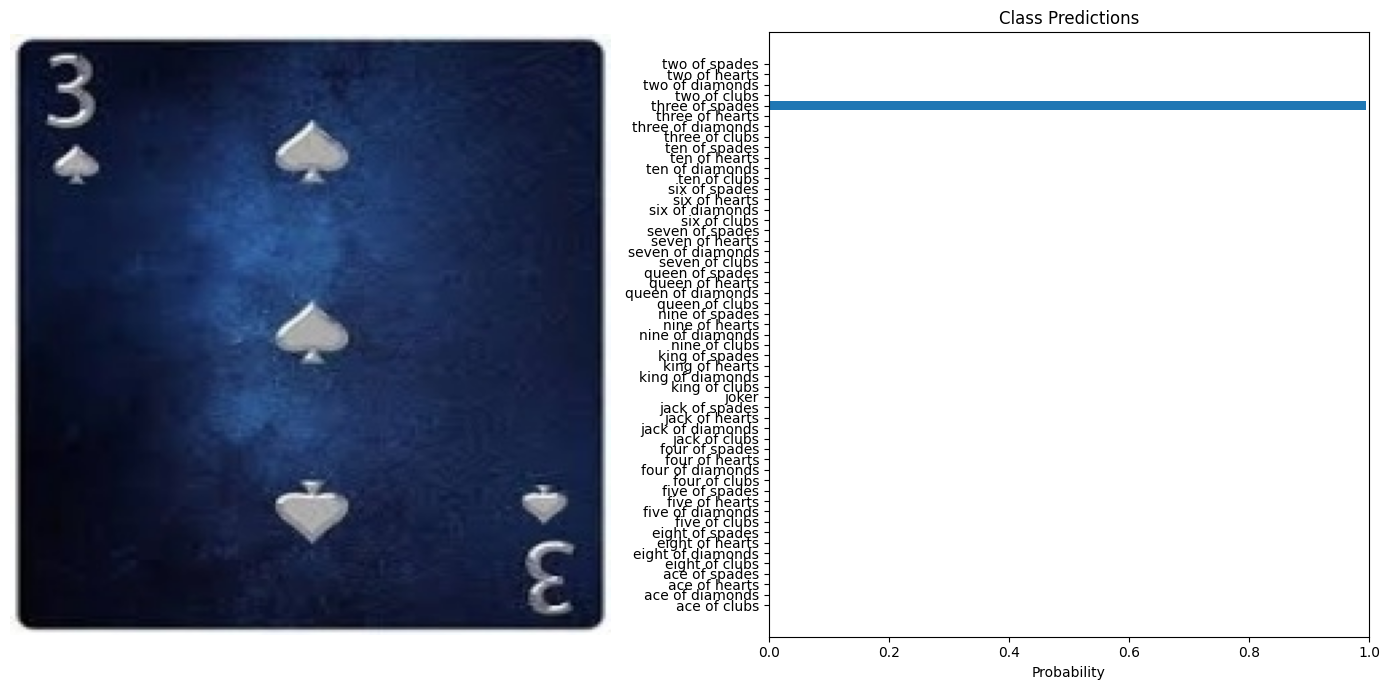

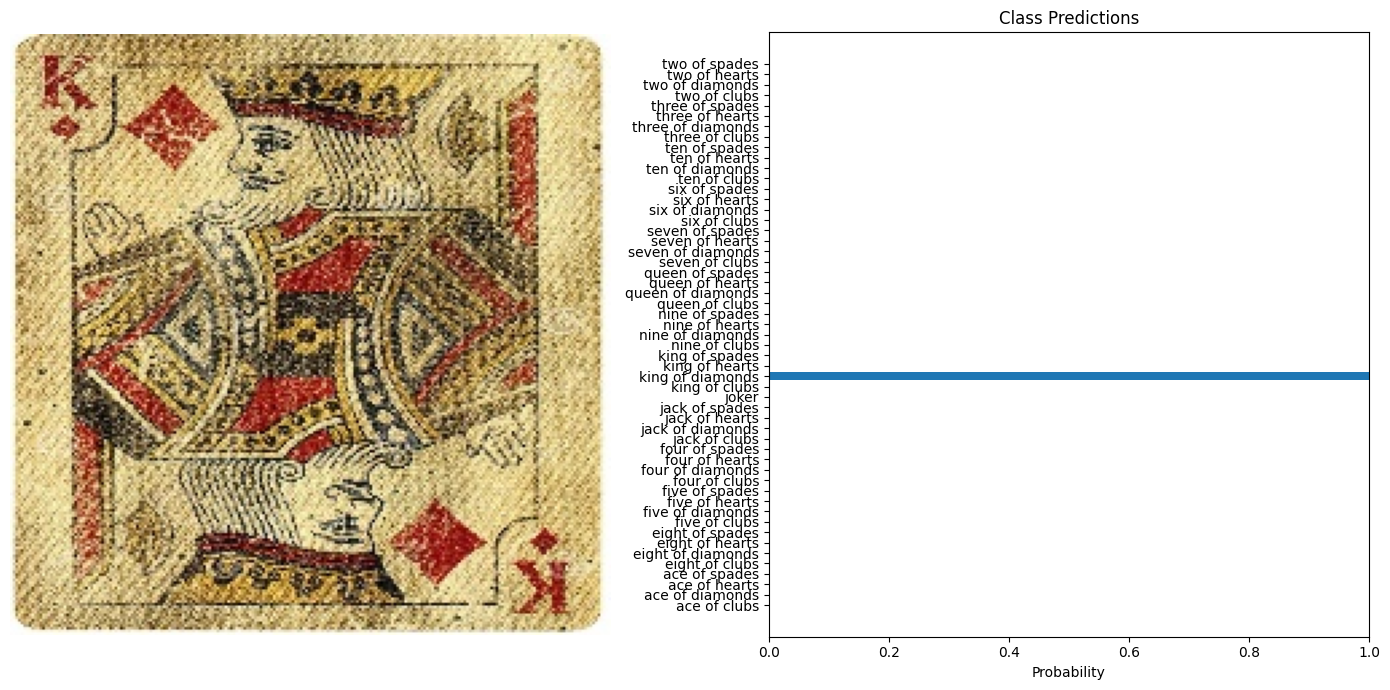

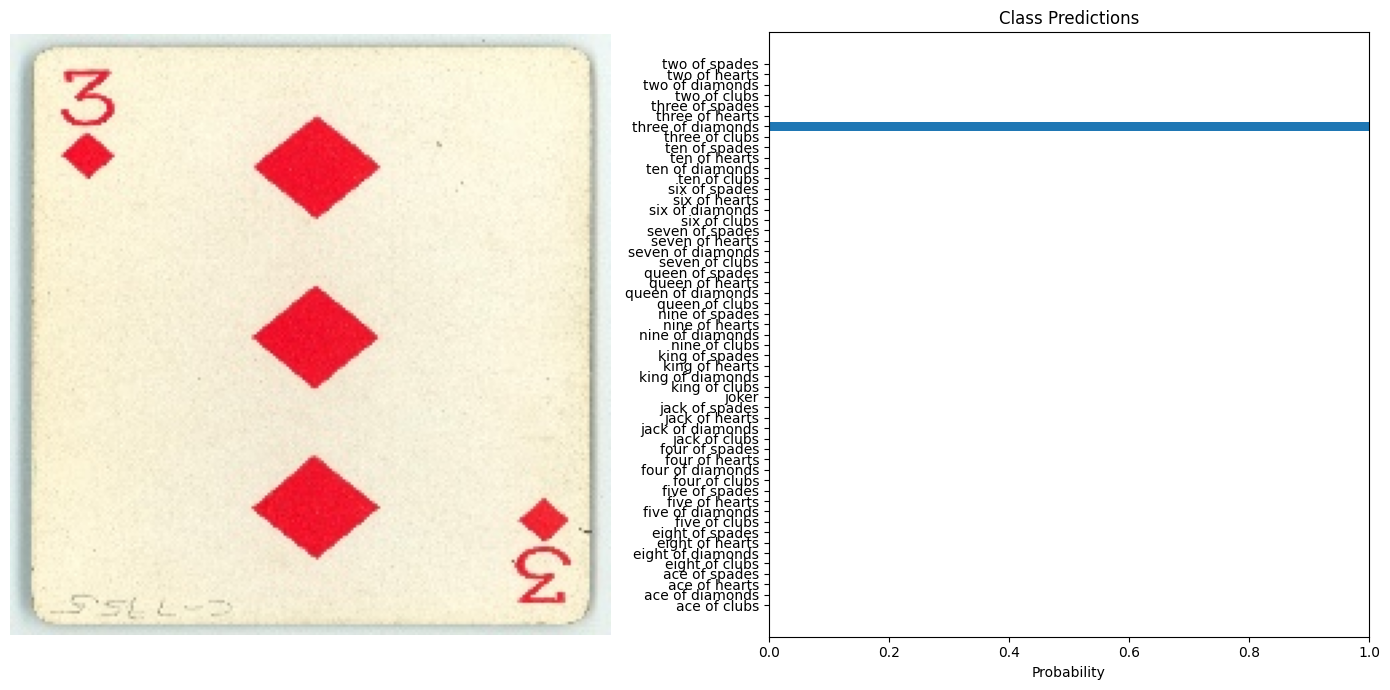

In [41]:
from glob import glob
test_images = glob('../data/playingcards/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)